# Process gridded CMIP6 model data into timeseries

__1. Process the gridded temperature data into timeseries for each model.__

Output is a dataArray for each model with dimensions of time and IPCC region containing a time series of the TAS variable.


Use this tool:  

https://github.com/IPCC-WG1/Atlas/blob/main/notebooks/reference-regions_Python.ipynb

Nathan notes that these models do the best job in CONUS:  MPI-ESM, GFDL-ESM2M, CESM1-CAM5, CanESM2.

__I already have access to two of them.__

_Need to figure out access to CMIP6 model PI-Control simulations._  

- Emailed Marika  
- Could talk to Zhu  
- Could email Nicola

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

__I developed the function in the file "preprocess1_timeseries_develop.ipynb".__ For better documentation, look there.

## Code!

In [48]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask
    )

from functions import (
    fix_cesm_time
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


__PI-Control Simulations.__  

Nicola/MPI: /glade/scratch/nmaher/mpi_jonah  

CESM1-LE: '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'


In [2]:
mpi_pic_dir = '/glade/scratch/nmaher/mpi_jonah/'
cesm1_pic_dir = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'

#### Collect CESM1 PIC file paths.

In [3]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [4]:
cesm1_pic_tas_files = glob.glob('%s/%s/b.e11.B1850C5CN.f09_g16.005*.nc' % (cesm1_pic_dir,cesm1_cmor_var_dict['tas']))
cesm1_pic_tas_files.sort()

cesm1_pic_ts_files = glob.glob('%s/%s/b.e11.B1850C5CN.f09_g16.005*.nc' % (cesm1_pic_dir,cesm1_cmor_var_dict['ts']))
cesm1_pic_ts_files.sort()

In [5]:
mpi_pic_tas_files = glob.glob('%s/%s/%s/*.nc' % (mpi_pic_dir,'tas','r001i1850p3/v20190123/'))
mpi_pic_tas_files.sort()

mpi_pic_ts_files = glob.glob('%s/%s/%s/*.nc' % (mpi_pic_dir,'ts','r001i1850p3/v20190123/'))
mpi_pic_ts_files.sort()

In [6]:
mpi_pic_tas_files

[]

Oh no, the MPI files are missing! They were probably removed because they were in Scratch. Well shit, I might need to email Nicola again.

Organize file paths into a dictionary indexed by the variable.

In [7]:
lens_vars = ['tas','ts',]

cesm1_pic_path_dict = {
    'tas':cesm1_pic_tas_files,
    'ts' :cesm1_pic_ts_files,
}

mpi_pic_path_dict = {
    'tas':mpi_pic_tas_files,
    'ts' :mpi_pic_ts_files,
}

### Load a process timeseries according to IPCC Region designations.

#### 1. Visualize the IPCC AR6 regions

In [8]:
import regionmask

regionmask.__version__

'0.9.0'

In [9]:
import cartopy.crs as ccrs
import matplotlib.patheffects as pe

In [50]:
def create_ipccregion_timeseries(_ds_filepath:str,_ds_var:str,regions:regionmask.Regions,cesm=False):
    
    '''
    Compute timeseries for all IPCC AR6 regions when given a simple model output file.
    '''

    # Load data
    ds      = xr.open_dataset(_ds_filepath,chunks={'lat':-1,'lon':-1})
    
    # Correct time if CESM
    if cesm:
        ds  = fix_cesm_time(ds)
    
    da      = ds[_ds_var]
    
    # Generate mask
    mask    = regions.mask(da)
    
    # Get unique region indices
    reg     = np.unique(mask.values)
    reg     = reg[~np.isnan(reg)]
    
    # for metadata: find abbreviations of all regions that were selected
    abbrevs = regions[reg].abbrevs
    names   = regions[reg].names
    
    # Compute weights for entire grid
    weights = np.cos(np.deg2rad(da.lat)) # assuming 'lat' used consistently
    
    # Iterate over regions and compute a weighted time series
    region_timeseries = []
    for i,_abbrev,_name in zip(reg,abbrevs,names):
        
        _region = da.where(mask == i)
        
        _region_avg = _region.weighted(weights).mean(dim=("lat", "lon")) # - 273.15
                
        # Using an int here should help with subsetting later.
        _region_avg = _region_avg.assign_coords({'RegionIndex':int(i)}).expand_dims('RegionIndex',axis=-1)

        # Include region abbreviation and name for easier use later
        _region_avg = _region_avg.assign_coords({'RegionAbbrev':_abbrev})
        _region_avg = _region_avg.assign_coords({'RegionName':_name})
        
        region_timeseries.append(_region_avg)
        
    region_timeseries_ds = xr.concat(region_timeseries,dim='RegionIndex')
    region_timeseries_ds.name = _ds_var
        
    return region_timeseries_ds

#### Loop over CESM1 PI-Control files and compute the regional means.

In [51]:
save_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC/'

In [55]:
model_subdir = 'CESM1/'

# Variable to select and operate over.
_ds_var = cesm1_cmor_var_dict['tas']

for _ds_filepath in cesm1_pic_path_dict['tas']:
    
    _regional_tseries_delayed = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,
                                                             _ds_var=_ds_var,
                                                             regions=regionmask.defined_regions.ar6.all,
                                                             cesm=True,
                                                            )
    
    _regional_tseries = _regional_tseries_delayed.compute()
    
    filename = _ds_filepath.split('/')[-1]
    
    _outfilepath = '%s/%s/%s' % (save_dir,model_subdir,filename)
    
    _regional_tseries.to_netcdf(path=_outfilepath)
    
    print(_outfilepath)

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC//CESM1//b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.040001-049912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC//CESM1//b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.050001-059912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC//CESM1//b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.060001-069912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC//CESM1//b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.070001-079912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC//CESM1//b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.080001-089912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC//CESM1//b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.090001-099912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC//CESM1//b.e11.B1850C5CN.f09_g16.005.cam.h0.TREFHT.100001-109912.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/CMIP6_PIC//CESM1//b.e11.B1850C5CN.f09_g16.005.cam.h0.

#### Check that files can be loaded and concatenated.

In [56]:
cesm1_pic_tseries_paths = glob.glob('%s/%s/*.nc' % (save_dir,model_subdir))
cesm1_pic_tseries_paths.sort()

In [57]:
cesm1_pic_all_tseries = xr.open_mfdataset(cesm1_pic_tseries_paths,chunks={'time':-1})

In [35]:
cesm1_pic_all_tseries['TREFHT'].chunk({'time':-1})

<xarray.DataArray 'TREFHT' (time: 21612, RegionIndex: 46)>
dask.array<rechunk-merge, shape=(21612, 46), dtype=float64, chunksize=(21612, 46), chunktype=numpy.ndarray>
Coordinates:
    RegionName    (RegionIndex) object dask.array<chunksize=(46,), meta=np.ndarray>
    RegionAbbrev  (RegionIndex) object dask.array<chunksize=(46,), meta=np.ndarray>
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45
  * time          (time) object 0400-02-01 00:00:00 ... 2201-01-01 00:00:00

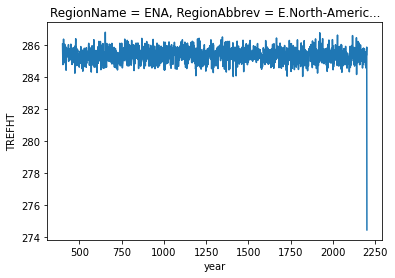

In [46]:
cesm1_pic_all_tseries['TREFHT'].sel(RegionIndex=5).groupby('time.year').mean('time').plot()

In [58]:
cesm1_pic_all_tseries.time

<xarray.DataArray 'time' (time: 21612)>
array([cftime.DatetimeNoLeap(400, 2, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(400, 3, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(400, 4, 1, 0, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2200, 11, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2200, 12, 1, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2201, 1, 1, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 0400-02-01 00:00:00 ... 2201-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds